In [1]:
from os import listdir, path
import torch
#torch.backends.cuda.matmul.allow_tf32 = True
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision.transforms.functional as VF
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import random
import json


In [2]:
BATCH_SIZE = 32
ROOT_DIR = "archive/"
PLOT_IMAGES = True
WIDTH, HEIGHT = 4*2**6, 3*2**6
TRAIN_VAL_RATIO = 19/20

with open(path.join(ROOT_DIR, "Labels.json"), "r") as f:
    translation_dict = json.load(f)

def onehot_to_dense(onehot_encoded, df):
    onehot_to_dense = df.columns[1:].to_list()
    dense_category = onehot_to_dense[np.argmax(onehot_encoded)]
    return translation_dict[dense_category]

In [3]:
train_dirs = [dir for dir in listdir(ROOT_DIR) if dir.startswith("train")]

image_paths, labels = [], []
for train_dir in  train_dirs:
    for dir in listdir(path.join(ROOT_DIR, train_dir)):
        for file in listdir(path.join(ROOT_DIR, train_dir, dir)):
            image_paths.append(path.join(ROOT_DIR, train_dir, dir, file))
            labels.append(dir)
len(image_paths)

130000

In [4]:
df = pd.DataFrame({"images": image_paths, "labels": labels})
df = pd.get_dummies(df, drop_first = False, columns = ["labels"], prefix = "", prefix_sep = "")
df

,images,n01440764,n01443537,n01484850,n01491361,n01494475,n01496331,n01498041,n01514668,n01514859,...,n02012849,n02013706,n02018207,n02018795,n02027492,n02028035,n02037110,n02051845,n02058221,n02077923
0,archive/train.X1/n01820546/n01820546_5794.JPEG,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,archive/train.X1/n01820546/n01820546_192.JPEG,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,archive/train.X1/n01820546/n01820546_2571.JPEG,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,archive/train.X1/n01820546/n01820546_3371.JPEG,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,archive/train.X1/n01820546/n01820546_497.JPEG,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129995,archive/train.X4/n01739381/n01739381_9976.JPEG,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
129996,archive/train.X4/n01739381/n01739381_2882.JPEG,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
129997,archive/train.X4/n01739381/n01739381_6296.JPEG,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
129998,archive/train.X4/n01739381/n01739381_10223.JPEG,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [5]:
np.random.seed(42)
random_indices = np.random.permutation(len(df))

train_df_length = int(TRAIN_VAL_RATIO * len(df))

train_df = df.iloc[random_indices[:train_df_length]]
val_df = df.iloc[random_indices[train_df_length:]]
len(train_df), len(val_df)

(123500, 6500)

In [6]:
class Imagenet100Dataset(Dataset):
    def __init__(self, df, image_size = (WIDTH, HEIGHT), transform = False):
        self.images_frame = df
        self.image_width, self.image_height = image_size
        self.transform = transform
        self.pil_to_tensor = T.PILToTensor()

    def __len__(self):
        return len(self.images_frame)
    
    def pad_and_resize(self, image, w, h):
        width, height = image.size

        if int(width * h / w) > height:
            padding = int((width * h / w - height) // 2)
            image = VF.pad(image, [0, padding])
        elif int(width * h / w) < height:
            padding = int((height * w / h - width) // 2)
            image = VF.pad(image, [padding, 0])
        
        image = VF.resize(image, (h, w))
        
        return image

    def __getitem__(self, idx):
        x = Image.open(self.images_frame.iloc[idx, 0]).convert("RGB")
        y = self.images_frame.iloc[idx, 1:].values.astype(np.int32)

        if self.transform:
            x = VF.rotate(x, -(30/2) + random.random() * 30, fill = 0, interpolation = Image.BILINEAR)

            #if x.size[0] < self.image_width or x.size[1] < self.image_height:

            #random_crop = T.Randomrop(size = (int(self.image_width * 1.25), int(self.image_height * 1.25)), padding = 1, pad_if_needed = True, padding_mode = "reflect")
            random_crop = T.RandomResizedCrop(size = (self.image_height, self.image_width))
            crop_params = random_crop.get_params(x, scale = (0.6, 1.4), ratio = (7/6, 5/3))
            x = VF.crop(x, *crop_params)
            x = self.pad_and_resize(x, self.image_width, self.image_height)

            if random.random() > 0.5:
                x = VF.hflip(x)

            x = VF.adjust_brightness(x, 1 - 0.3 + random.random() * 0.4)
            x = VF.adjust_contrast(x, 1 - 0.3 + random.random() * 0.4)
            x = VF.adjust_saturation(x, 1 - 0.4 + random.random() * 0.4)
            x = VF.adjust_hue(x, -0.1 + random.random() * 0.2)
        
        else:
            x = self.pad_and_resize(x, self.image_width, self.image_height)
        
        x = self.pil_to_tensor(x) / 255

        return x, y

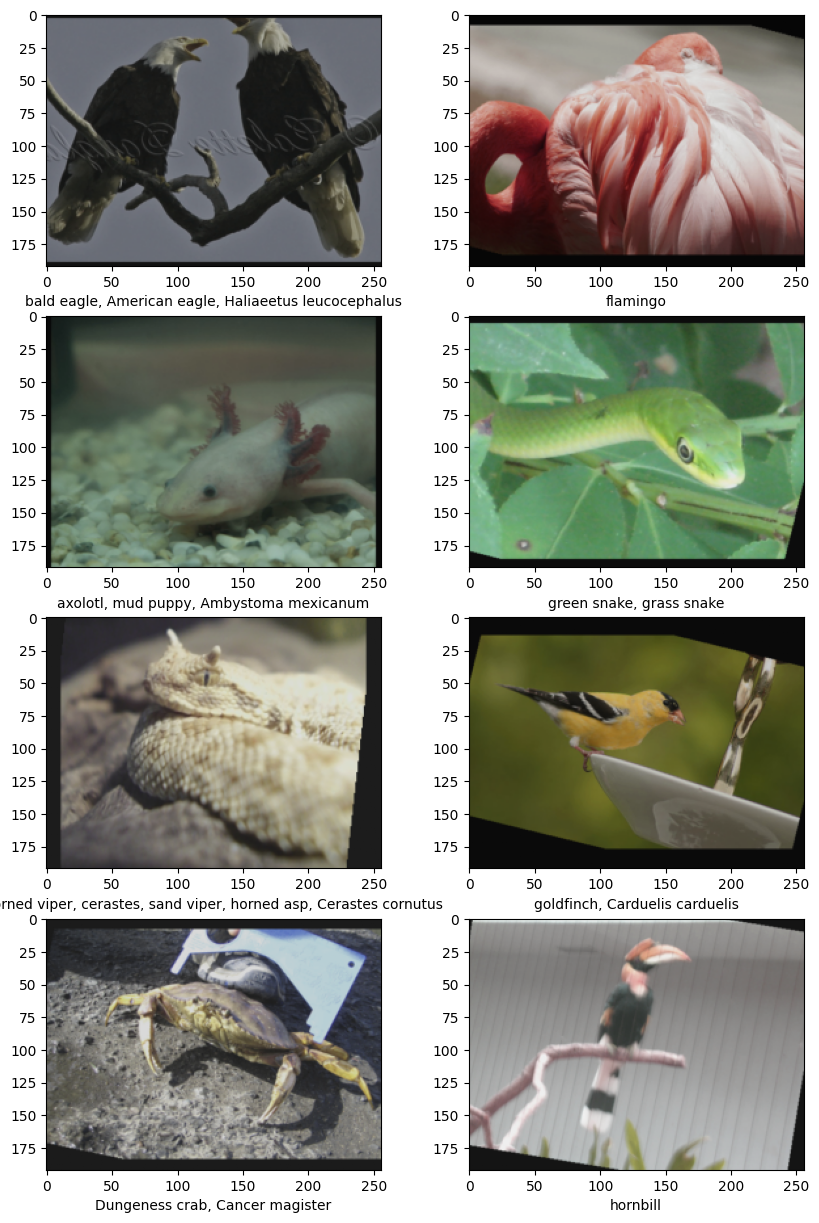

In [7]:
if PLOT_IMAGES:
    augmentation_test = Imagenet100Dataset(train_df, transform = True)
    augment_test_loader = DataLoader(augmentation_test, batch_size = BATCH_SIZE, shuffle = False, pin_memory = True, num_workers = 4)
    images, labels = next(iter(augment_test_loader))
    images = images[:8]
    labels = labels[:8]

    fig, axs = plt.subplots(4, 2, figsize = (10, 15))

    for i, (image, label) in enumerate(zip(images.detach().numpy(), labels.detach().numpy())):
        image = image.swapaxes(0, 2).swapaxes(0, 1)
        axs[i // 2 , i % 2].imshow(image)
        axs[i // 2 , i % 2].set_xlabel(onehot_to_dense(label, df))

    plt.show()

In [8]:
class MBConv(nn.Module):
    def __init__(self, input_channels, output_channels, expansion = 4, half_size = True):
        super().__init__()
        expanded_channels = input_channels * expansion
        self.conv_1 = nn.Conv2d(input_channels, expanded_channels, 3, 2 if half_size else 1, 1)
        self.conv_2 = nn.Conv2d(expanded_channels, output_channels, 1, 1)
        self.norm = nn.BatchNorm2d(output_channels)

        if input_channels != output_channels:
            self.shortcut = nn.Conv2d(input_channels, output_channels, 1, 1)
        else:
            self.shortcut = None

    def forward(self, x):
        res = x
        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        x = self.norm(x)
        if self.shortcut:
            res = self.shortcut(res)
        res = F.max_pool2d(res, 2, 2, 0)
        x += res
        return x
    
class Net100(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.pooling = nn.MaxPool2d(2, 2, 0)

        self.initial_conv = nn.Conv2d(3, 16, 3, 2, 1)
        self.MBBlock_1 = MBConv(16, 32)
        self.MBBlock_2 = MBConv(32, 64)
        self.MBBlock_3 = MBConv(64, 128)

        self.linear_1 = nn.Linear(512, 256)
        self.linear_2 = nn.Linear(256, 100)
    
    def forward(self, x):
        x = self.initial_conv(x)
        x = self.pooling(x)
        x = self.MBBlock_1(x)
        x = self.pooling(x)
        x = self.MBBlock_2(x)
        x = self.pooling(x)
        x = self.MBBlock_3(x)
        x = torch.flatten(x, start_dim = 1)
        x = F.relu(self.linear_1(x))
        x = self.linear_2(x)

        return x


x = torch.randn((32, 3, HEIGHT, WIDTH))
Net100()(x).shape

torch.Size([32, 100])

In [9]:
"""class Conv2dBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv2d_1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 2, padding = 1)
        self.batchnorm = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        x = F.leaky_relu(self.batchnorm(self.conv2d_1(x)))
        return x

class Net100(nn.Module):
    def __init__(self):
        super().__init__()
        self.maxpool = nn.MaxPool2d(2, stride = 2, padding = 0)
        self.conv2dblock_1 = Conv2dBlock(3, 32)
        self.conv2dblock_2 = Conv2dBlock(32, 64)
        self.conv2dblock_3 = Conv2dBlock(64, 128)
        self.conv2dblock_4 = Conv2dBlock(128, 256)
        #self.oneby = nn.Conv2d(128, 20, 1, 1)

        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 100)

    def forward(self, x):
        x = self.conv2dblock_1(x)
        x = self.maxpool(x)
        x = self.conv2dblock_2(x)
        x = self.maxpool(x)
        x = self.conv2dblock_3(x)
        x = self.maxpool(x)
        x = self.conv2dblock_4(x)
        x = self.maxpool(x)
        #return x
        #x = self.oneby(x)
        x = torch.flatten(x, start_dim = 1)
        #return x
        x = F.leaky_relu(self.linear_1(x))
        x = self.linear_2(x)
        return x

    

net = Net100()
net(torch.rand(32, 3, HEIGHT, WIDTH)).shape"""

'class Conv2dBlock(nn.Module):\n    def __init__(self, in_channels, out_channels):\n        super().__init__()\n        self.conv2d_1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 2, padding = 1)\n        self.batchnorm = nn.BatchNorm2d(out_channels)\n    \n    def forward(self, x):\n        x = F.leaky_relu(self.batchnorm(self.conv2d_1(x)))\n        return x\n\nclass Net100(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.maxpool = nn.MaxPool2d(2, stride = 2, padding = 0)\n        self.conv2dblock_1 = Conv2dBlock(3, 32)\n        self.conv2dblock_2 = Conv2dBlock(32, 64)\n        self.conv2dblock_3 = Conv2dBlock(64, 128)\n        self.conv2dblock_4 = Conv2dBlock(128, 256)\n        #self.oneby = nn.Conv2d(128, 20, 1, 1)\n\n        self.linear_1 = nn.Linear(256, 128)\n        self.linear_2 = nn.Linear(128, 100)\n\n    def forward(self, x):\n        x = self.conv2dblock_1(x)\n        x = self.maxpool(x)\n        x = self.conv2dblock_2(x)\n  

In [14]:
image_train = Imagenet100Dataset(train_df, transform = True)
train_loader = DataLoader(image_train, batch_size = BATCH_SIZE, shuffle = True, pin_memory = True, num_workers = 4)

validation_dataset = Imagenet100Dataset(val_df, transform = False)
validation_loader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle = False, pin_memory = True, num_workers = 4)

In [11]:
model = Net100()

In [18]:
print(str(sum(p.numel() for p in model.parameters() if p.requires_grad)) + " trainable parameters")

406116 trainable parameters


In [26]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

scaler = torch.cuda.amp.GradScaler()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
#model.to(device = device, memory_format = torch.channels_last)

In [15]:
model.to(device = device)

MIXED_PRECISION = False
NUM_EPOCHS = 40

for epoch in range(NUM_EPOCHS):
    tqdm_loop = tqdm(train_loader)
    train_loss, validation_loss = [], []

    model.train()
    for features, targets in tqdm_loop:
        #features = features.to(device = device, non_blocking = True, memory_format = torch.channels_last)
        #targets = targets.to(device = device, non_blocking = True, memory_format = torch.channels_last)
        features = features.to(device = device, non_blocking = True)
        targets = targets.to(device = device, non_blocking = True)
        optimizer.zero_grad()
        targets = torch.argmax(targets, axis = 1)

        if MIXED_PRECISION:
            with torch.cuda.amp.autocast():
                predictions = model(features)
                loss = loss_function(predictions, targets)
            scaler.scale(loss).backward()
        else:
            predictions = model(features)
            loss = loss_function(predictions, targets)
            loss.backward()

        optimizer.step()
        train_loss.append(loss.item())
        
        tqdm_loop.set_description(f"Epoch [{epoch + 1}/{NUM_EPOCHS}]")
        tqdm_loop.set_postfix(loss = np.mean(train_loss))

    model.eval()
    with torch.no_grad():
        for features, targets in validation_loader:
            features = features.to(device, non_blocking = True)
            targets = targets.to(device, non_blocking = True)

            targets = torch.argmax(targets, axis = 1)
            predictions = model(features)
            loss = loss_function(predictions, targets)
            validation_loss.append(loss.item())
        print(f"Validation loss: {np.mean(validation_loss):.5f}")

Epoch [1/40]: 100%|██████████| 3860/3860 [10:19<00:00,  6.24it/s, loss=2.7] 


Validation loss: 2.55173


Epoch [2/40]: 100%|██████████| 3860/3860 [10:16<00:00,  6.27it/s, loss=2.45]


Validation loss: 2.52890


Epoch [3/40]: 100%|██████████| 3860/3860 [09:58<00:00,  6.45it/s, loss=2.35]


Validation loss: 2.44484


Epoch [4/40]: 100%|██████████| 3860/3860 [10:03<00:00,  6.40it/s, loss=2.28]


Validation loss: 2.44077


Epoch [5/40]: 100%|██████████| 3860/3860 [09:57<00:00,  6.46it/s, loss=2.24]


Validation loss: 2.37865


Epoch [6/40]: 100%|██████████| 3860/3860 [09:42<00:00,  6.63it/s, loss=2.19]


Validation loss: 2.37054


Epoch [7/40]: 100%|██████████| 3860/3860 [09:40<00:00,  6.65it/s, loss=2.15]


Validation loss: 2.43378


Epoch [8/40]: 100%|██████████| 3860/3860 [09:41<00:00,  6.64it/s, loss=2.12]


Validation loss: 2.39604


Epoch [9/40]: 100%|██████████| 3860/3860 [09:41<00:00,  6.63it/s, loss=2.09]


Validation loss: 2.31922


Epoch [10/40]: 100%|██████████| 3860/3860 [09:40<00:00,  6.65it/s, loss=2.06]


Validation loss: 2.36925


Epoch [11/40]: 100%|██████████| 3860/3860 [09:42<00:00,  6.62it/s, loss=2.03]


Validation loss: 2.43704


Epoch [12/40]: 100%|██████████| 3860/3860 [09:43<00:00,  6.61it/s, loss=2.01]


Validation loss: 2.24269


Epoch [13/40]: 100%|██████████| 3860/3860 [09:41<00:00,  6.64it/s, loss=1.99]


Validation loss: 2.29979


Epoch [14/40]: 100%|██████████| 3860/3860 [09:42<00:00,  6.63it/s, loss=1.97]


Validation loss: 2.24920


Epoch [15/40]: 100%|██████████| 3860/3860 [09:39<00:00,  6.66it/s, loss=1.95]


Validation loss: 2.25872


Epoch [16/40]: 100%|██████████| 3860/3860 [09:40<00:00,  6.64it/s, loss=1.94]


Validation loss: 2.24224


Epoch [17/40]: 100%|██████████| 3860/3860 [09:39<00:00,  6.66it/s, loss=1.92]


Validation loss: 2.28251


Epoch [18/40]: 100%|██████████| 3860/3860 [09:43<00:00,  6.61it/s, loss=1.9] 


Validation loss: 2.24770


Epoch [19/40]: 100%|██████████| 3860/3860 [09:42<00:00,  6.63it/s, loss=1.89]


Validation loss: 2.28150


Epoch [20/40]: 100%|██████████| 3860/3860 [10:00<00:00,  6.43it/s, loss=1.87]


Validation loss: 2.28179


Epoch [21/40]: 100%|██████████| 3860/3860 [09:48<00:00,  6.56it/s, loss=1.86]


Validation loss: 2.21824


Epoch [22/40]: 100%|██████████| 3860/3860 [09:55<00:00,  6.48it/s, loss=1.84]


Validation loss: 2.24209


Epoch [23/40]: 100%|██████████| 3860/3860 [09:51<00:00,  6.53it/s, loss=1.83]


Validation loss: 2.19765


Epoch [24/40]: 100%|██████████| 3860/3860 [09:39<00:00,  6.66it/s, loss=1.82]


Validation loss: 2.22671


Epoch [25/40]: 100%|██████████| 3860/3860 [09:39<00:00,  6.66it/s, loss=1.8] 


Validation loss: 2.41280


Epoch [26/40]: 100%|██████████| 3860/3860 [09:38<00:00,  6.67it/s, loss=1.79]


Validation loss: 2.17452


Epoch [27/40]: 100%|██████████| 3860/3860 [09:40<00:00,  6.65it/s, loss=1.78]


Validation loss: 2.22816


Epoch [28/40]: 100%|██████████| 3860/3860 [09:41<00:00,  6.64it/s, loss=1.77]


Validation loss: 2.20232


Epoch [29/40]: 100%|██████████| 3860/3860 [09:55<00:00,  6.48it/s, loss=1.76]


Validation loss: 2.17554


Epoch [30/40]: 100%|██████████| 3860/3860 [10:07<00:00,  6.35it/s, loss=1.75]


Validation loss: 2.19702


Epoch [31/40]: 100%|██████████| 3860/3860 [09:40<00:00,  6.65it/s, loss=1.74]


Validation loss: 2.18455


Epoch [32/40]: 100%|██████████| 3860/3860 [09:38<00:00,  6.67it/s, loss=1.72]


Validation loss: 2.19340


Epoch [33/40]: 100%|██████████| 3860/3860 [09:40<00:00,  6.65it/s, loss=1.72]


Validation loss: 2.18504


Epoch [34/40]: 100%|██████████| 3860/3860 [09:50<00:00,  6.54it/s, loss=1.7] 


Validation loss: 2.17819


Epoch [35/40]: 100%|██████████| 3860/3860 [09:59<00:00,  6.44it/s, loss=1.7] 


Validation loss: 2.14103


Epoch [36/40]: 100%|██████████| 3860/3860 [09:41<00:00,  6.64it/s, loss=1.69]


Validation loss: 2.21091


Epoch [37/40]: 100%|██████████| 3860/3860 [09:42<00:00,  6.63it/s, loss=1.68]


Validation loss: 2.17793


Epoch [38/40]: 100%|██████████| 3860/3860 [09:39<00:00,  6.66it/s, loss=1.67]


Validation loss: 2.23525


Epoch [39/40]: 100%|██████████| 3860/3860 [09:41<00:00,  6.64it/s, loss=1.66]


Validation loss: 2.17718


Epoch [40/40]: 100%|██████████| 3860/3860 [09:43<00:00,  6.61it/s, loss=1.65]


Validation loss: 2.14673


In [16]:
print(str(sum(p.numel() for p in model.parameters() if p.requires_grad)) + " trainable parameters")

406116 trainable parameters


In [17]:
torch.save(model.state_dict(), "test1")

In [11]:
model = Net100()
model.load_state_dict(torch.load("test1"))
model.eval()

Net100(
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (initial_conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (MBBlock_1): MBConv(
    (conv_1): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (MBBlock_2): MBConv(
    (conv_1): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_2): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (MBBlock_3): MBConv(
    (conv_1): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_2): Conv2d(256, 128, kernel_size=(1, 1), stride

In [12]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.linear_1.register_forward_hook(get_activation('linear_1'))


In [41]:
embeddings_dataset = Imagenet100Dataset(df)
embeddings_dataset_loader = DataLoader(embeddings_dataset, batch_size = 32, shuffle = False, num_workers = 3)

In [43]:
embeddings = None

model.to(device = device)
model.eval()
with torch.no_grad():
    for features, targets in embeddings_dataset_loader:
        features = features.to(device, non_blocking = True)

        predictions = model(features)
        vector_embeddings = activation["linear_1"]

        if embeddings is None:
            embeddings = activation["linear_1"]
        else:
            embeddings = torch.concat([embeddings, activation["linear_1"]])

# Runtime: 5m 27s
        

In [66]:
embeddings = embeddings.to("cpu")
embeddings.shape

torch.Size([130000, 256])

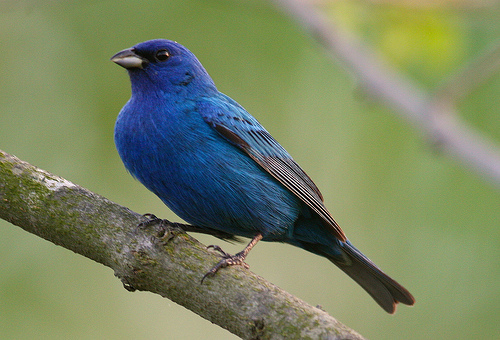

In [14]:
image = Image.open("archive/train.X2/n01537544/n01537544_16.JPEG")
image

In [15]:
image = augmentation_test.pad_and_resize(image, WIDTH, HEIGHT)
image = (T.PILToTensor()(image) / 255).unsqueeze(0)
image.shape

torch.Size([1, 3, 192, 256])

In [48]:
model.cpu()
output = model(image)
onehot_to_dense(output.detach().numpy(), df)

'indigo bunting, indigo finch, indigo bird, Passerina cyanea'

In [65]:
test_image_vector = activation["linear_1"]
test_image_vector = test_image_vector.cpu()
test_image_vector.shape

torch.Size([1, 256])

In [90]:
test_image_vector

tensor([[-10.6294,   3.2443,   2.7712,   2.4470,   4.4600,  -8.3843,   3.0432,
           0.1605,  -1.0396,   1.5414,  -5.9166,   1.5385,  -3.9535,  -2.0342,
          -6.6034,  -9.9048,  -0.4512,  -5.7782,   2.3577,   2.9984,   1.7109,
          -4.3660, -11.9535,   5.2393,  -6.0490,   4.8414,   3.8757,   0.7713,
           0.2778,  -1.1657,   0.8274,   0.3190,   2.3146,  -4.0301,   0.3094,
           2.0188,  -2.8104,   9.6624,   1.3390,   7.2281, -13.7745,  -4.3397,
           3.0048,   0.0308,  -3.7318,  -2.0886,   0.4911,   6.4781,   2.3846,
          -3.9371,  -3.9053,   5.7570,  -5.2911,  -3.9081,  -3.0018,   0.1046,
           2.0699,  -5.8769,  -7.4480,   9.1540,  -5.9392,  -2.6579,   2.8683,
          10.5875,  10.9015,  -3.4168, -13.5631,   3.5616,  -4.4024, -10.6459,
           5.8568,  -0.3068,  -0.0180,  -3.8532,  -7.9860,  -1.4867,   0.7332,
           1.6090,   4.1946,  10.6031,  -2.7406,  -9.2101,   7.2306,   1.6356,
          -1.1210,  -7.7203,   5.9086,  -2.5118,  -7

In [70]:
similarity_indices = F.cosine_similarity(test_image_vector, embeddings)
similarity_indices.shape

# Runtime: 0.2 s

torch.Size([130000])

In [74]:
df["smilarity_index"] = similarity_indices.detach().numpy()
df

,images,n01440764,n01443537,n01484850,n01491361,n01494475,n01496331,n01498041,n01514668,n01514859,...,n02013706,n02018207,n02018795,n02027492,n02028035,n02037110,n02051845,n02058221,n02077923,smilarity_index
0,archive/train.X1/n01820546/n01820546_5794.JPEG,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.449771
1,archive/train.X1/n01820546/n01820546_192.JPEG,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.155257
2,archive/train.X1/n01820546/n01820546_2571.JPEG,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.243663
3,archive/train.X1/n01820546/n01820546_3371.JPEG,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.386181
4,archive/train.X1/n01820546/n01820546_497.JPEG,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.219735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129995,archive/train.X4/n01739381/n01739381_9976.JPEG,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.202391
129996,archive/train.X4/n01739381/n01739381_2882.JPEG,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.212816
129997,archive/train.X4/n01739381/n01739381_6296.JPEG,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.285256
129998,archive/train.X4/n01739381/n01739381_10223.JPEG,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.063610


In [85]:
similar_images = df.sort_values(by = "smilarity_index", ascending = False)[:6]
similar_images

,images,n01440764,n01443537,n01484850,n01491361,n01494475,n01496331,n01498041,n01514668,n01514859,...,n02013706,n02018207,n02018795,n02027492,n02028035,n02037110,n02051845,n02058221,n02077923,smilarity_index
90903,archive/train.X2/n01537544/n01537544_16.JPEG,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1.000000
90527,archive/train.X2/n01537544/n01537544_3941.JPEG,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.883531
90352,archive/train.X2/n01537544/n01537544_1921.JPEG,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.879991
90846,archive/train.X2/n01537544/n01537544_4577.JPEG,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.876296
89768,archive/train.X2/n01537544/n01537544_17006.JPEG,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.871009
89873,archive/train.X2/n01537544/n01537544_9671.JPEG,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.868253


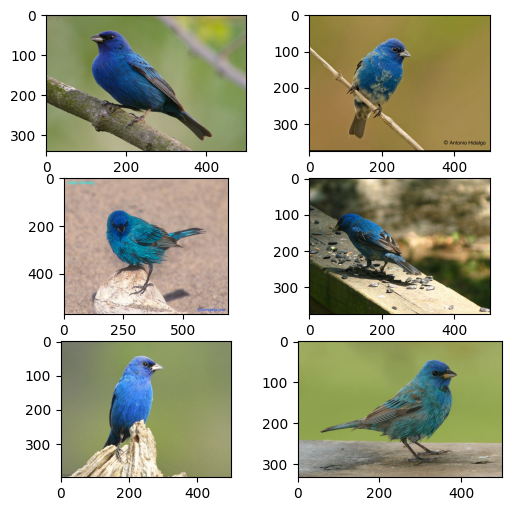

In [89]:
fig, ax = plt.subplots(3, 2, figsize = (6, 6))

for i, path in enumerate(similar_images["images"].to_list()):
    ax[i // 2, i % 2].imshow(Image.open(path))